In [1]:
import pandas as pd
import numpy as np
import sys
from torch import optim
from torch.nn import BCEWithLogitsLoss, MSELoss
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader , random_split
sys.path.append("../")
from tqdm import tqdm
from tcad.deep.fit import train_CNN, evaluate_CNN
from tcad.deep.models import CNN
from tcad.tools.nntools import SmilesDataSet
from tcad.tools.datatools import to_log_p
from sklearn.decomposition import PCA

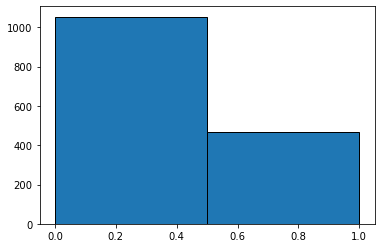

In [2]:
data = pd.read_csv("../data/androgen_data.csv")
smiles = data["canonical_smiles"].to_list()

ACTIVITY_LVL = 5.5
labels = to_log_p(list(data['standard_value']))
labels = [1 if value < ACTIVITY_LVL else 0 for value in labels]

plt.hist(labels,2, edgecolor='black')
plt.show()

In [3]:
split_ratio = 0.3
dataset = SmilesDataSet(smiles, labels)
train_data, test_data  = random_split(dataset, [round(len(dataset) * (1 - split_ratio)), round(len(dataset) * split_ratio)])
train_dataloader = DataLoader(train_data, batch_size=128,)
test_dataloader = DataLoader(test_data, batch_size=128)

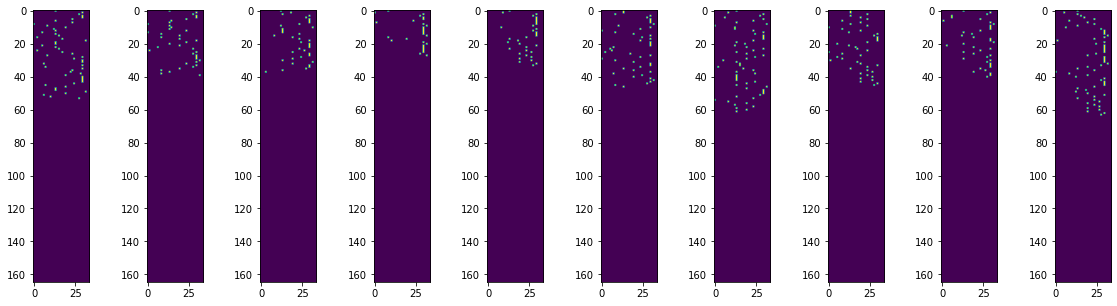

In [4]:
encoded_smiles, label= next(iter(train_dataloader))
_, ax = plt.subplots(1, 10, figsize = (20, 5))
for i in range(10):
    ax[i].imshow(encoded_smiles[i].squeeze())

100%|██████████| 10/10 [08:36<00:00, 51.65s/it]


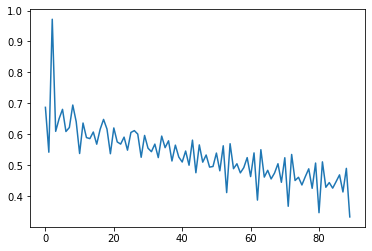

In [22]:
losses =[]

model = CNN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = BCEWithLogitsLoss()

for _ in tqdm(range(10)):
    losses.extend(train_CNN(model, train_dataloader, criterion=criterion, optimizer=optimizer))

plt.plot(losses)


In [23]:
evaluate_CNN(model, test_dataloader)

21.93

In [15]:
outs = []
labls = []

for batch, labels in train_dataloader:
    out = model(batch, encode=True)
    outs.append(out.detach().cpu().numpy())
    labls.append([label.item() for label in labels])

for idx, (out, lbl) in enumerate(zip(outs, labls)):
    
    if idx==0:
        result = out
        labels = lbl
    result = np.vstack((result, out))
    labels = labels+lbl
labels = ["green" if var==1 else "red" for var in labels]

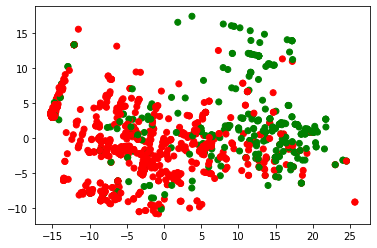

In [16]:
pca = PCA(2)
comp = pca.fit_transform(result)

plt.scatter(x=comp[:,0], y=comp[:,1], c=labels)
plt.show()